In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image




ModuleNotFoundError: No module named 'torch'

Define parameters. Similar to CNN that we explored before. 

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
latent_dim = 20
hidden_dim = 16
batch_size = 128
epochs = 20
learning_rate = 1e-3

# MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# CVAE model
class CVAE(nn.Module):
    def __init__(self, latent_dim, hidden_dim):
        super(CVAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, hidden_dim, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten()
        )

        self.fc_mu = nn.Linear(hidden_dim * 7 * 7, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim * 7 * 7, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (hidden_dim, 7, 7)),
            nn.ConvTranspose2d(hidden_dim, hidden_dim, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(hidden_dim, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        log_var = self.fc_logvar(x)
        z = self.reparameterize(mu, log_var)
        reconstructed = self.decoder(z)
        return reconstructed, mu, log_var

model = CVAE(latent_dim, hidden_dim).to(device)

# Loss function
def loss_fn(reconstructed, x, mu, log_var):
    reconstruction_loss = nn.BCELoss(reduction='sum')(reconstructed, x)
    kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return reconstruction_loss + kl_divergence

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [1]:
# Training
total_steps = len(train_loader)
for epoch in range(epochs):
    for i, (images, _) in enumerate(train_loader):
        images = images.to(device)
        
        # Forward pass
        reconstructed, mu, log_var = model(images)
        loss = loss_fn(reconstructed, images, mu, log_var)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{total_steps}], Loss: {loss.item():.4f}')

# Generate and save sample images
with torch.no_grad():
    # Generate random latent vectors
    z = torch.randn(batch_size, latent_dim).to(device)
    generated = model.decoder(z).cpu()
    save_image(generated.view(generated.size(0), 1, 28, 28), 'generated_samples.png')

# Save the trained model
torch.save(model.state_dict(), 'cvae_model.pth')

Epoch [1/20], Step [100/469], Loss: -3431116.2500
Epoch [1/20], Step [200/469], Loss: -3407157.5000
Epoch [1/20], Step [300/469], Loss: -3378056.2500
Epoch [1/20], Step [400/469], Loss: -3449300.7500
Epoch [2/20], Step [100/469], Loss: -3421046.0000
Epoch [2/20], Step [200/469], Loss: -3371421.7500
Epoch [2/20], Step [300/469], Loss: -3501955.0000
Epoch [2/20], Step [400/469], Loss: -3556976.0000
Epoch [3/20], Step [100/469], Loss: -3511111.0000
Epoch [3/20], Step [200/469], Loss: -4136954.5000
Epoch [3/20], Step [300/469], Loss: -3881751.7500
Epoch [3/20], Step [400/469], Loss: -4268615.5000
Epoch [4/20], Step [100/469], Loss: -5230705.0000
Epoch [4/20], Step [200/469], Loss: -5977470.5000
Epoch [4/20], Step [300/469], Loss: -6057869.0000
Epoch [4/20], Step [400/469], Loss: -6353562.0000
Epoch [5/20], Step [100/469], Loss: -6594374.0000
Epoch [5/20], Step [200/469], Loss: -6724852.0000
Epoch [5/20], Step [300/469], Loss: -6960642.0000
Epoch [5/20], Step [400/469], Loss: -7106445.5000


In [5]:
# Create a new instance of the model
model = CVAE(latent_dim, hidden_dim).to(device)

# Load the saved model's state dict
model.load_state_dict(torch.load('cvae_model.pth'))

<All keys matched successfully>

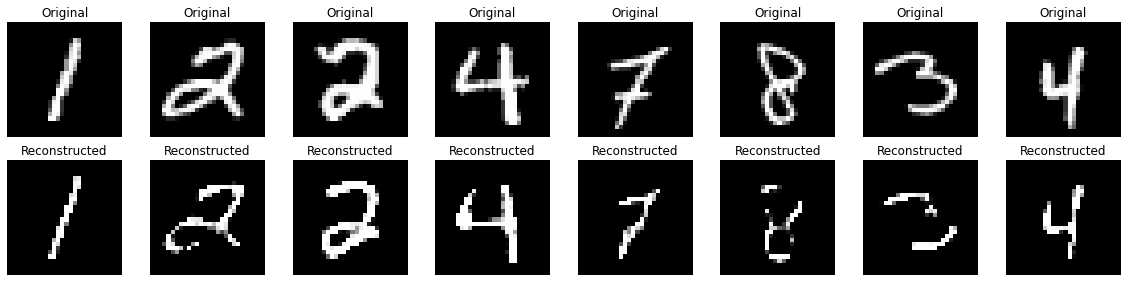

In [8]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained model
model = CVAE(latent_dim, hidden_dim).to(device)
model.load_state_dict(torch.load('cvae_model.pth'))
model.eval()

# Get a batch of test data
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform) # Test dataset
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=True)
test_batch, _ = next(iter(test_loader))
test_batch = test_batch.to(device)

# Generate predictions using the trained model
with torch.no_grad():
    reconstructed_batch, _, _ = model(test_batch)

# Convert tensors to numpy arrays
original_images = test_batch.cpu().numpy()
reconstructed_images = reconstructed_batch.cpu().numpy()

# Plot the original and reconstructed images side by side
fig, axes = plt.subplots(nrows=2, ncols=8, figsize=(16, 4))

for i in range(8):
    # Original image
    axes[0, i].imshow(original_images[i].squeeze(), cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title('Original')

    # Reconstructed image
    axes[1, i].imshow(reconstructed_images[i].squeeze(), cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title('Reconstructed')

plt.tight_layout()
plt.show()


Output is similar to input. So what's the purpose? <br>
The decompressed outputs even seems to be degraded compared to the original inputs. So why bother? 

There are two reasons. <br>
(1) Dimensionality reduction: the latent space representation of the data is typically smaller than original one.  
(2) Data denoising: see the following example. 

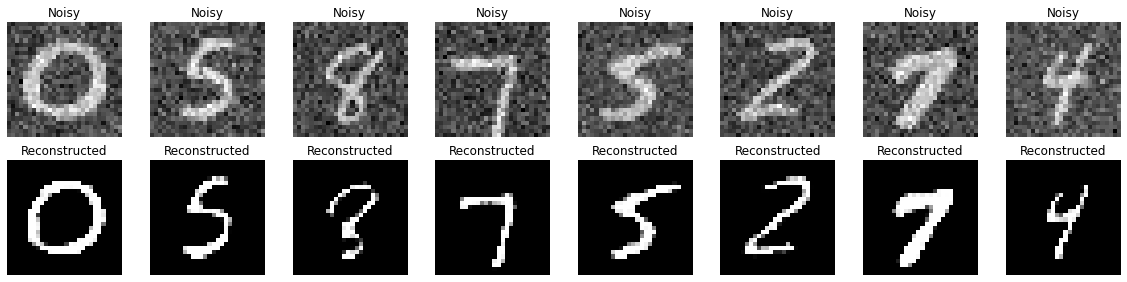

In [15]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained model
model = CVAE(latent_dim, hidden_dim).to(device)
model.load_state_dict(torch.load('cvae_model.pth'))
model.eval()

# Get a batch of test data
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=True)
test_batch, _ = next(iter(test_loader))
test_batch = test_batch.to(device)

# Define the standard deviation of the Gaussian noise
noise_stddev = 0.4

# Add Gaussian noise to the test data
noise = torch.randn_like(test_batch) * noise_stddev
noisy_test_batch = test_batch + noise

# Generate reconstructions from the noisy test data
with torch.no_grad():
    reconstructed_batch, _, _ = model(noisy_test_batch)

# Convert tensors to numpy arrays
noisy_images = noisy_test_batch.cpu().numpy()
reconstructed_images = reconstructed_batch.cpu().numpy()

# Plot the noisy and reconstructed images side by side
fig, axes = plt.subplots(nrows=2, ncols=8, figsize=(16, 4))

for i in range(8):
    # Noisy image
    axes[0, i].imshow(noisy_images[i].squeeze(), cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title('Noisy')

    # Reconstructed image
    axes[1, i].imshow(reconstructed_images[i].squeeze(), cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title('Reconstructed')

plt.tight_layout()
plt.show()


Homework for you: <br>
(1) Train the autoencoder on your own devices with MNIST data, and try to input other images that are <br>
a) two digit numbers<br>
b) not numbers (i.e. English letter, Greek letter, Kanji, your own handwriting, etc.)<br>
Note the input images will have to be black and white. If you encounter problems, try asking ChatGPT to explain the problems to you. Of course, your lecturers and TAs will be happy to help as well. 

(2) Research about the strength and weakness of CNN. Find the intuitions of convolutional kernels and motivations of using convolutional kernels. Again, use ChatGPT, your lecturers, and TAs when neccessary. <br>

(3) Find other applications of CNN. 

Please post your solution on Slack or send me your solution to jack7z@bu.edu 